In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as tf
import numpy as np
import matplotlib.pyplot as plt
from itertools import pairwise
import math
from typing import Optional, Union, Tuple
from accelerate import Accelerator
import os


In [2]:
rawdatapath = 'PRJ_AUTO_NOISEPARAM/data/raw/ANMO/*'
procsavepath = 'PRJ_AUTO_NOISEPARAM/data/processed/ANMO'
procsavepathfile = os.path.join(procsavepath, 'anmo_noise_data.pkl')

if os.path.isfile(procsavepathfile) == 1:
    with open(procsavepathfile, 'rb') as f:
        trainset = pickle.load(f)
else:
    trainset = process_seismic_data(rawdatapath,procsavepath)
    with open(procsavepathfile, 'wb') as f:
        pickle.dump(trainset, f)

        

NameError: name 'os' is not defined

In [26]:
##Generating the dataset
class Swissroll(Dataset):
    def __init__(self, tmin, tmax, N):
        t = tmin + torch.linspace(0, 1, N) * tmax
        self.vals = torch.stack([t*torch.cos(t)/tmax, t*torch.sin(t)/tmax]).T

    def __len__(self):
        return len(self.vals)

    def __getitem__(self, i):
        return self.vals[i]
    

 ##Deciding how noise will be sampled    
class Schedule:
    def __init__(self, sigmas: torch.FloatTensor):
        self.sigmas = sigmas
    def __getitem__(self, i) -> torch.FloatTensor:
        return self.sigmas[i]
    def __len__(self) -> int:
        return len(self.sigmas)
    
    def sample_batch(self, x0:torch.FloatTensor) -> torch.FloatTensor:
        #rndint returns random integers uniformly distributed from min to max values. This controls the intersity of the noise.
        #epsilion is the noise with mean 0 and std 1.
        #print(len(self), (x0.shape[0],))
        return self[torch.randint(len(self), (x0.shape[0],))].to(x0) 
    
    def sample_sigmas(self, steps: int) -> torch.FloatTensor:
        indices = list((len(self) * (1 - np.arange(0, steps)/steps))
                       .round().astype(np.int64) - 1)
        return self[indices + [0]]
    

##Deciding how noise will be sampled. sigma is divided between min and max into N distinct values.
##schedule class will then sample randomly from this N values.
class ScheduleLogLinear(Schedule):
    def __init__(self, N: int, sigma_min: float=0.02, sigma_max: float=10):
        super().__init__(torch.logspace(math.log10(sigma_min), math.log10(sigma_max), N))


#Positional Embedding of the Signal
def get_sigma_embeds(sigma):
    #return torch.ones_like(sigma) #this line doesnt work
    sigma = sigma.unsqueeze(1)
    return torch.cat([torch.sin(torch.log(sigma)/2),
                      torch.cos(torch.log(sigma)/2)], dim=1)

class TimeInputMLP(nn.Module):
    def __init__(self, dim, hidden_dims):
        super().__init__()
        layers = []
        for in_dim, out_dim in pairwise((dim + 2,) + hidden_dims): #adding 2 becuase of the positional embedding of the noise
            layers.extend([nn.Linear(in_dim, out_dim), nn.GELU()])
        layers.append(nn.Linear(hidden_dims[-1], dim))
        self.net = nn.Sequential(*layers)
        self.input_dims = (dim,)

    def rand_input(self, batchsize):
        return torch.randn((batchsize,) + self.input_dims)

    def forward(self, x, sigma):
        #sigma_embeds = get_sigma_embeds(x) ##this idea line of code desnt work
        
        sigma_embeds = get_sigma_embeds(sigma)         # shape: b x 2
        nn_input = torch.cat([x, sigma_embeds], dim=1) # shape: b x (dim + 2) #concats the positional 2d embedding of the noise
        return self.net(nn_input)

    def predict_eps(self, x, sigma, cond=None):
        return self(x, sigma)

    def predict_eps_cfg(self, x, sigma, cond=None, cfg_scale=0):
        if cond is None or cfg_scale == 0:
            return self.predict_eps(x, sigma, cond=cond)
        assert sigma.shape == tuple(), 'CFG sampling only supports singleton sigma!'
        uncond = torch.full_like(cond, self.cond_embed.null_cond) # (B,)
        eps_cond, eps_uncond = self.predict_eps(                  # (B,), (B,)
            torch.cat([x, x]), sigma, torch.cat([cond, uncond])   # (2B,)
        ).chunk(2)
        return eps_cond + cfg_scale * (eps_cond - eps_uncond)


def generate_train_sample(x0: torch.FloatTensor, schedule: Schedule):
    sigma = schedule.sample_batch(x0)
    eps = torch.randn_like(x0)
    return sigma, eps


def training_loop(loader  : DataLoader,
                  model   : nn.Module,
                  schedule: Schedule,
                  epochs  : int = 10000):
    optimizer = optim.Adam(model.parameters())
    loss_track = []
    for _ in range(epochs):
        for x0 in loader:
            #x0 = torch.cat([x0[:,0].unsqueeze(1), x0[:,1].unsqueeze(1)], dim=0)
            #x0 = x0[:,0].unsqueeze(1)+x0[:,1].unsqueeze(1)
            tmin = np.pi / 2
            tmax = 5 * np.pi
            N = len(x0)
            #t_original = tmin + torch.linspace(0, 1, N) * tmax
            dt = tmax / (N - 1)
            time_ax = torch.tensor(np.arange(tmin, tmin + tmax + dt, dt))  # Use np.arange for consistent step size
            #time_ax_rev = torch.flip(time_ax,[0]) -didnt' give great results
            #time_ax = t = tmin + torch.linspace(0, 1, N) * tmax

            data_temp = (x0[:,1].unsqueeze(1)+x0[:,0].unsqueeze(1))/2
            x0 = torch.cat([time_ax.unsqueeze(-1), data_temp], dim=1).float() #time_ax_rev.unsqueeze(-1) ##not using this in concat
            optimizer.zero_grad()
            sigma, eps = generate_train_sample(x0, schedule)
            eps_hat = model(x0 + sigma.unsqueeze(1) * eps, sigma)
            loss = nn.MSELoss()(eps_hat, eps)
            loss.backward()
            optimizer.step()
        loss_track.append(loss.item())
    return loss_track


@torch.no_grad()
def samples(model      : nn.Module,
            sigmas     : torch.FloatTensor, # Iterable with N+1 values for N sampling steps
            gam        : float = 1.,        # Suggested to use gam >= 1
            mu         : float = 0.,        # Requires mu in [0, 1)
            cfg_scale  : int = 0.,          # 0 means no classifier-free guidance
            batchsize  : int = 1,
            xt         : Optional[torch.FloatTensor] = None,
            cond       : Optional[torch.Tensor] = None,
            accelerator: Optional[Accelerator] = None):
    xt = model.rand_input(batchsize) * sigmas[0] if xt is None else xt
    if cond is not None:
        assert cond.shape[0] == xt.shape[0], 'cond must have same shape as x!'
        cond = cond.to(xt.device)
    eps = None
    for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
        model.eval()
        eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), None, 0)
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()
        xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
        yield xt
            

In [27]:
dataset = Swissroll(np.pi/2, 5*np.pi,200)
dataloader = DataLoader(dataset, batch_size=2048)
data = next(iter(dataloader))
data_temp = data[:,1].unsqueeze(1)+data[:,0].unsqueeze(1)
data_temp = data_temp.squeeze(1)
print(data_temp.shape)

schedule = ScheduleLogLinear(N=200, sigma_min=0.005, sigma_max=10)
sigma, eps = generate_train_sample(data_temp, schedule)
print(sigma.shape, eps.shape)

torch.Size([200])
torch.Size([200]) torch.Size([200])


torch.Size([200, 2])


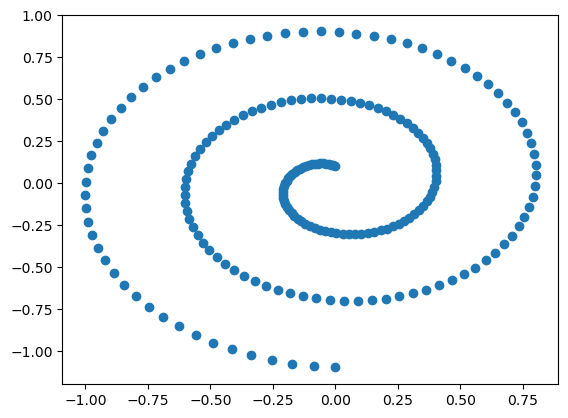

In [12]:
dataset = Swissroll(np.pi/2, 5*np.pi,200)
dataloader = DataLoader(dataset, batch_size=2048)

data = next(iter(dataloader))
print(data.shape)
plt.scatter(data[:,0], data[:,1])

In [ ]:
tmin = np.pi / 2
tmax = 5 * np.pi
N = 200
t_original = tmin + torch.linspace(0, 1, N) * tmax
dt = tmax / (N - 1)
t_equiv = torch.tensor(np.arange(tmin, tmin + tmax + dt, dt))  # Use np.arange for consistent step size
t_equiv.unsqueeze(-1).shape
torch.flip(t_equiv,[0]).unsqueeze(-1).shape
print(dt)

torch.Size([200, 1])

torch.Size([200, 2])


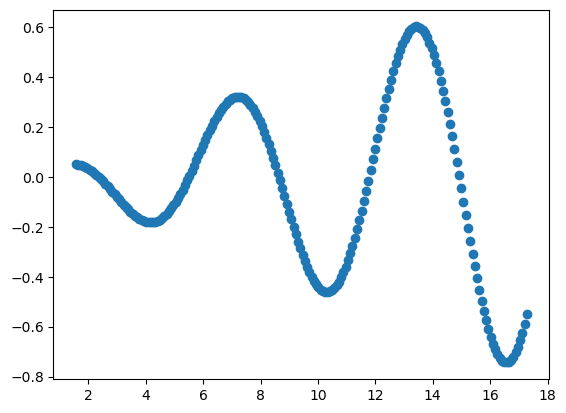

In [14]:
#plt.plot(torch.cat([data[:,0].unsqueeze(1), data[:,1].unsqueeze(1)], dim=0).flatten())

data_temp = (data[:,1].unsqueeze(1)+data[:,0].unsqueeze(1))/2
time_ax = torch.tensor(list(range(0,200)))
data_temp = torch.cat([time_ax.unsqueeze(-1), data_temp], dim=1)
print(data_temp.shape)
#data_temp = data_temp.squeeze(1).unsqueeze(0)


plt.scatter(t_equiv,data_temp[:,1])
plt.show()
#plt.plot(data.flatten().unsqueeze(1).numpy())
# for i, j in pairwise((1 + 2,) + (16,128,128,128,128,16)):
#     print(i,j)

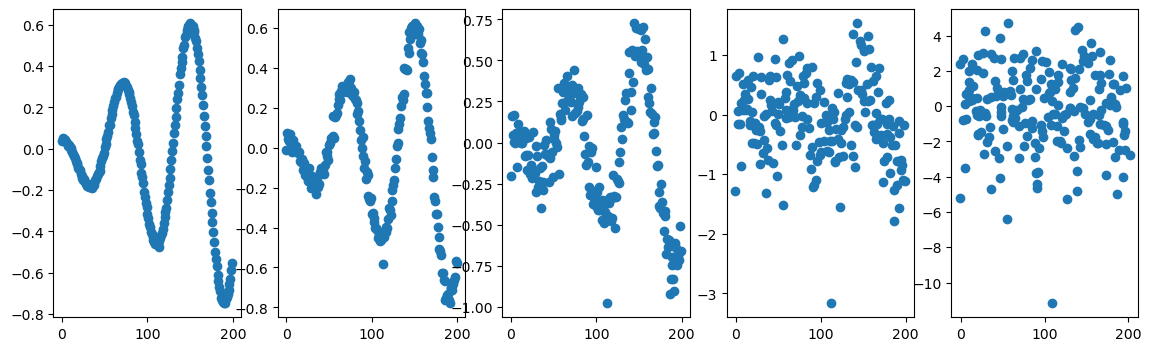

In [15]:
stepsize = int(200/5)
schedule = ScheduleLogLinear(N=200, sigma_min=0.005, sigma_max=10)
sigma, eps = generate_train_sample(data_temp, schedule)
sigma = torch.tensor(sorted(sigma))
plt.figure(figsize=(14,4))
c=1
for i in range(1,200,stepsize):
    plt.subplot(1,5,c)
    #val = torch.sqrt(sigma.unsqueeze(1)[50//i]) * data_temp + torch.sqrt(1 - sigma.unsqueeze(1)[50//i]) * eps
    val = data_temp + sigma.unsqueeze(1)[i] * eps
    #val = data_temp * sigma.unsqueeze(1)[i] + (1 - sigma.unsqueeze(1)[i]) * eps
    plt.scatter(val[:,0],val[:,1])
    c+=1


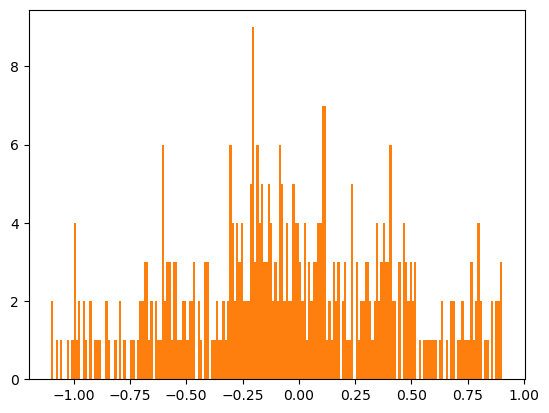

torch.Size([400, 1])


In [237]:
plt.hist(data.flatten().numpy(), bins=200)
temp = torch.cat([data[:,0].unsqueeze(1), data[:,1].unsqueeze(1)], dim=0)
plt.hist(temp.flatten(),bins=200)
plt.show()
print(temp.shape)

In [28]:
dataset = Swissroll(np.pi/2, 5*np.pi,200)
dataloader = DataLoader(dataset, batch_size=2000)

In [29]:
model = TimeInputMLP(dim=2, hidden_dims=(16,128,128,128,128,16))
schedule = ScheduleLogLinear(N=1000, sigma_min=0.005, sigma_max=10)
model.train()
trainer  = training_loop(dataloader, model, schedule, epochs=15000)
#losses   = [ns.loss.item() for ns in trainer]

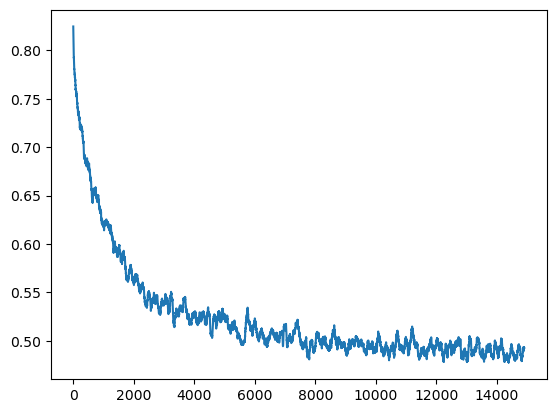

In [ ]:
plt.plot(np.convolve(trainer, np.ones(100)/100, mode='valid'))

In [31]:
samp_arr=np.zeros([100,2])
for i in range(0,20):
    model.eval()
    samp_list = []
    for i in range(0,100):
        *xts, x0 = samples(model, schedule.sample_sigmas(10).unsqueeze(-1),gam=2)
        samp_list.append(x0.numpy())
    val = np.array(samp_list).squeeze(1)
    val = sorted(val, key=lambda x: x[0])   
    samp_arr = samp_arr+val
samp_arr = samp_arr/20

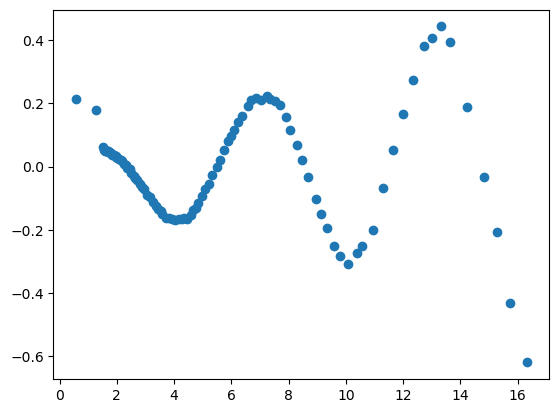

In [ ]:

plt.scatter(samp_arr[:,0],samp_arr[:,1])